# Initalize libaries and file name
## !!!(YOU NEED TO PIP INSTALL h5py)!!! "conda install h5py" in console

In [67]:
file_name = 'A1 Pre-Galling Test.xyz'
xyz_folder_name = "A - 316L Rod"

# These need to be defined based on resolution, and hence and predefined before running the rest of the code
X_res = 2.576 #um #
Y_res = X_res #um
# Input Units: m
unit_conversion_xy = 1e3 # convert to mm
unit_conversion_z = 1e6 #um. #1e3 # convert to mm

# Set font size here
fsize = 20

# --------------------------------------------------------------------------------------------------------------------------------------------------------

#Grab those libaries, I ain't writing shit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from mpl_toolkits import mplot3d

# Set global font to Times New Roman and font size to 10pt
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 10

import random
from statistics import mean
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import TwoSlopeNorm
#from matplotlib.mlab import griddata
from scipy import interpolate
import h5py

import scipy
from scipy import stats
import math
import time

# Code File Location
file_dir = os.path.dirname("Profilometry Analysis Code - Kit")
# Source Files relative to this file
csv_path = os.path.join(file_dir,"..","xyz Files",xyz_folder_name,file_name)

# Create the output file name based on the input file name
output_file_name = file_name.replace('.xyz', '_piv.txt')

# Replace the file extension for the output CSV file
saving_file_name = file_name.replace('.xyz', '_processed.h5')

# This is the conversion of the raw data to format the code wants

# Main body of the code, does missing data interpolation and tilt correction

Read the CSV file
(4960, 4977)
Pivoted the DataFrame
Replaced missing data with NaN 
Saved processed data to A1 Pre-Galling Test_piv.txt
Function execution time: 10.29 seconds
Edge size / mm:  0.2
Left Edge: 235 Right Edge: 4734 Top Edge: 215 Bottom Edge: 4706
X0:  2460
Y0:  2484
-----------------------------------------
Moving Point Average / - :  15
Number of Standard Deviations from Mean Allowed:  1
Edges Max height / um:  -91.8322988065218
Edges Min height / um:  -199.1007597238
Edges Rt / um 107.26846091727819
-----------------------------------------
Total Filtering Time (s):  47.063112020492554
Interpolation Time (s):  66.2324161529541
Time for first tilt correction (s):  69.06882834434509
Time for second tilt correction (s):  71.74249911308289
Time for third tilt correction (s):  74.38644409179688
Position of modal bin (counts):  92 - 94
Z-correction factor:  93.0
------------------------
Corrected Edgeless Max height / um:  6.783086712333699
Corrected Edgless Min height / um: 

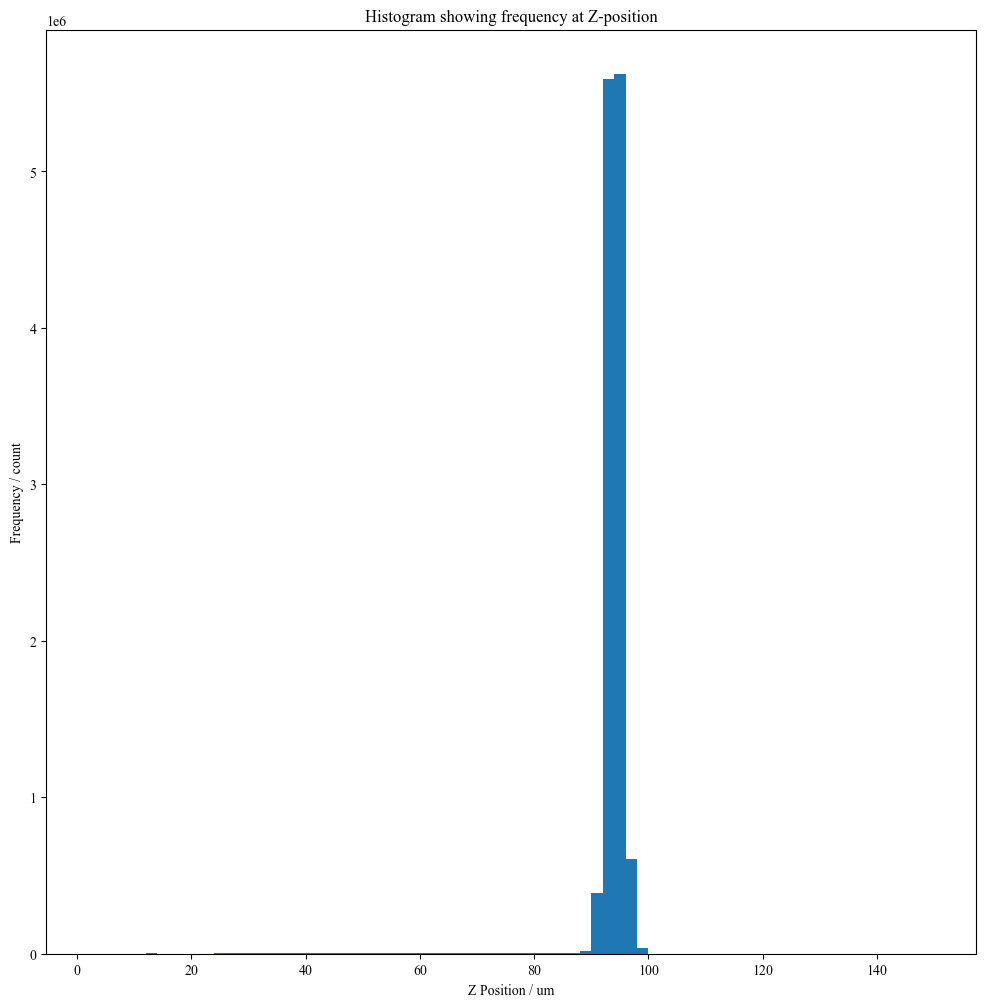

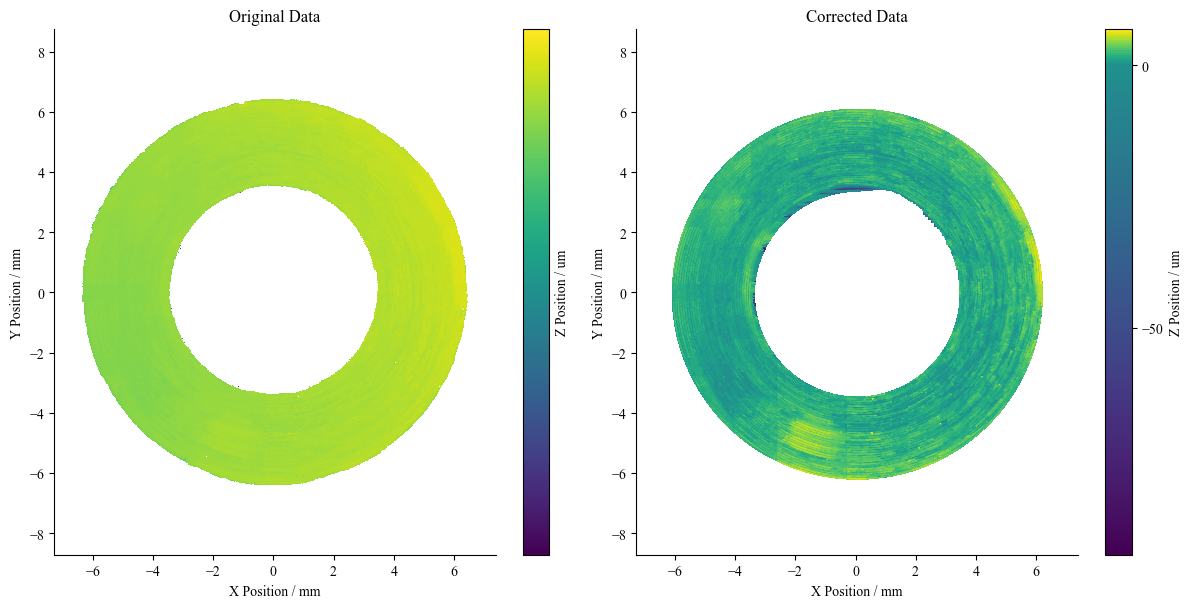

Finished!
Time elapsed:  130.45037817955017  seconds


In [70]:
start_time = time.time()

#Step 0: Read, convert, and save

# Read the CSV file, treating multiple spaces as a single delimiter
unprocessed_data = pd.read_csv(csv_path, sep='\\s+', skiprows=4, usecols=[0,1,2]) # skiprows=14) for Imperial's Data
print('Read the CSV file')

# Drop the last column
#unprocessed_data = unprocessed_data.iloc[:, :-1]
#print('Dropped the last column')


# Assuming the DataFrame has the structure [X, Y, Z]
unprocessed_data.columns = ['X', 'Y', 'Z']  # Assign column names if needed
unprocessed_data['X'] = unprocessed_data['X'].astype('float64') *unit_conversion_xy
unprocessed_data['Y'] = unprocessed_data['Y'].astype('float64') *unit_conversion_xy
unprocessed_data['Z'] = unprocessed_data['Z'].astype('float64') *unit_conversion_z

#total_nan_count_unprocessed = unprocessed_data.isna().sum()
#print('Unprocessed data NaN count ',total_nan_count_unprocessed)

# Pivot the DataFrame to create the 2D map
pivot_table = unprocessed_data.pivot_table(index='Y', columns='X', values='Z')
print(np.shape(pivot_table))
#print(pivot_table)
print('Pivoted the DataFrame')

unprocessed_data = unprocessed_data.iloc[:-1]
print('Replaced missing data with NaN ')#and dropped the last row')

#total_nan_count = np.isnan(pivot_table).sum().sum()
#print('Post pivot NaN count ', total_nan_count)

# Save the cleaned and pivoted DataFrame to the new file
# pivot_table.to_csv(output_file_name, index=0, header=1)
np.savetxt(output_file_name, pivot_table, delimiter=",")
print(f"Saved processed data to {output_file_name}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Function execution time: {elapsed_time:.2f} seconds")


#Step 1: Read the data
#------------#------------#------------#------------#------------#------------#------------#------------
# Read data
A = pd.read_csv(output_file_name)

# This grabs all the real data from our now 2D array
raw_data = A.iloc[:,1:]

# Definitions:

edge = 0.2 #distance (mm) from sample edges to be ignored during tilt correction
print('Edge size / mm: ', edge)

# Filtering parameters
moving_average = 15 - 1 # must be even?????
std_range = 1 #Number of standard deviations from mean which is accepted


# Edge points for centre
min_points = 500 # Minimum number of data points in a row/column that we'll consider as being a relevant row/column for calculating the mid-point

# Sample shape and resolution
mean_res = (X_res+Y_res)/2000 # in mm, different resolution in X & Y
outer_radius = (6.35 - edge)/mean_res # in px, the standard is 6.35
inner_radius = (3.21 + edge)/mean_res # in px, the standard is 3.1875

#Step 2: Find the mid point
#------------#------------#------------#------------#------------#------------#------------#------------
'''
def find_edge(data, minimum_points):
    for i in range(data.shape[0]):
        data_slice = raw_data.iloc[int(i),:].astype(float)
        if np.isnan(data_float.values).sum() < raw_data.shape[1]-(min_points-1):
            return i

left_edge = find_edge(raw_data, min_points)
right_edge = find_edge(raw_data.iloc[:, ::-1], min_points)
top_edge = find_edge(raw_data.T, min_points)
bottom_edge = find_edge(raw_data.T.iloc[:, ::-1], min_points)
'''
for i in range(0, (raw_data.shape[1])): #[row, col]
    data_slice = raw_data.iloc[:,int(i)] #slice for column
    data_float = data_slice.astype(np.float64) #float64 datatype necessary for np.isnan command to work
    if np.isnan(data_float. values).sum() < raw_data.shape[0]-(min_points-1): #i.e. at least 10 data points
        left_edge = i
        break
    else :
        ()
        
for i in range((raw_data.shape[1] - 1), -1, -1):#[row, col]
    data_slice = raw_data.iloc[:,int(i)] #slice for column
    data_float = data_slice.astype(np.float64) #float64 datatype necessary for np.isnan command to work
    if np.isnan(data_float. values).sum() < raw_data.shape[0]-(min_points-1): #i.e. at least 10 data points
        right_edge = i
        break
    else :
        ()
        
        
for i in range(0, (raw_data.shape[0])):#[row, col]
    data_slice = raw_data.iloc[int(i), :] #slice for column
    data_float = data_slice.astype(np.float64) #float64 datatype necessary for np.isnan command to work
    if np.isnan(data_float. values).sum() < raw_data.shape[1]-(min_points-1): #i.e. at least 10 data points
        top_edge = i
        break
    else :
        ()
        
for i in range((raw_data.shape[0] - 1), -1, -1):#[row, col]
    data_slice = raw_data.iloc[int(i), :] #slice for column
    data_float = data_slice.astype(np.float64) #float64 datatype necessary for np.isnan command to work
    if np.isnan(data_float. values).sum() < raw_data.shape[1]-(min_points-1): #i.e. at least 10 data points
        bottom_edge = i
        break
    else :
        ()

#Transpose to match physical specimen
raw_data = (pd.DataFrame(data=raw_data).T).astype(float)
raw_data = pd.DataFrame(data=raw_data)
raw_data = raw_data*1

#Define sample centres: X & Y apparently swapped due to dataframe being transposed
Y0 = int(round(mean((left_edge, right_edge)),0)) #since the dataset has been transposed
X0 = int(round(mean((top_edge, bottom_edge)),0)) #since the dataset has been transposed


print("Left Edge:", left_edge, "Right Edge:", right_edge, 
      "Top Edge:", top_edge, "Bottom Edge:", bottom_edge)
print('X0: ', X0)
print('Y0: ', Y0)
print('-----------------------------------------')

#Define X & Y axes from dataset

X = (np.linspace(0, raw_data.shape[1]-1, raw_data.shape[1])-X0)*X_res/1000 # 1px = 2.554862 um

Y = (np.linspace(0, raw_data.shape[0]-1, raw_data.shape[0])-Y0)*Y_res/1000 # 1px = 2.558354 um


#Step 3: Cut off the edges of the data before filtering
#------------#------------#------------#------------#------------#------------#------------#------------

#Removing Y-edges
Y_edge_removal = 1*raw_data


#Construction of outer and inner radii to remove edge effects


#Outside of left outer edge (i.e. i<Xoutneg)
for i in range(0, int(X0-outer_radius)+1, 1):
    Y_edge_removal.iloc[i,:] = np.nan

#Outside of right outer edge (i.e. i>Xoutneg)
for i in range(int(X0+outer_radius)+1, raw_data.shape[0], 1):
    Y_edge_removal.iloc[i,:] = np.nan

#Outside of lower outer edge (i.e. i<Y_outer_negative)
for i in range(0, int(Y0-outer_radius)+1, 1):
    Y_edge_removal.iloc[:, i] = np.nan

#Outside of upper outer edge (i.e. i>Y_outer_negative)
for i in range(int(Y0+outer_radius)+1, raw_data.shape[1], 1):
    Y_edge_removal.iloc[:, i] = np.nan
     
    
#Between Xout and Xin (for both sides)
for i in range(int(X0-outer_radius)+1, int(X0)+1, 1):
    Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
    Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))
    
    Y_edge_removal.iloc[i, 0:Y_outer_negative] = np.nan
    Y_edge_removal.iloc[i, Y_outer_positive:Y_edge_removal.shape[1]-1] = np.nan

for i in range(int(X0), int(X0+outer_radius), 1):
    Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
    Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))

    Y_edge_removal.iloc[i, 0:Y_outer_negative] = np.nan
    Y_edge_removal.iloc[i, Y_outer_positive:Y_edge_removal.shape[1]-1] = np.nan

#Between Xinneg and Xinpos (hole in middle as a single section)
for i in range(int(X0-inner_radius+1), int(X0+inner_radius-1), 1):
    #Outer portion
    Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
    Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))
    
    Y_edge_removal.iloc[i,0:Y_outer_negative] = np.nan
    Y_edge_removal.iloc[i, Y_outer_positive:Y_edge_removal.shape[1]-1] = np.nan
        
    #Inner portion
    Y_inner_positive = int(Y0 + math.sqrt(inner_radius**2 - (i-X0)**2))
    Y_inner_negative = int(Y0 - math.sqrt(inner_radius**2 - (i-X0)**2))
    
    Y_edge_removal.iloc[i, Y_inner_negative:Y_inner_positive] = np.nan

edgeless_data = Y_edge_removal


#Step 4: Filter noise
#------------#------------#------------#------------#------------#------------#------------#------------

#Filtering of data
#Excluding data outside of mean+x*standarddeviations, where x = std (below) and the mean is found using a moving average
print('Moving Point Average / - : ', moving_average+1)
print('Number of Standard Deviations from Mean Allowed: ', std_range)

def filter_from_moving_average(data, window, std_range):
    flat_data = data.to_numpy().flatten()
    series_data = pd.Series(flat_data)
    rolling_mean = series_data.rolling(window=window, min_periods=1).mean()
    rolling_std = series_data.rolling(window=window, min_periods=1).std()
    
    for i in range(window // 2, len(flat_data) - window // 2):
        if abs(rolling_mean[i] - flat_data[i]) >= abs(std_range * rolling_std[i]):
            flat_data[i] = np.nan
    return pd.DataFrame(flat_data.reshape(data.shape))

filtered_edgeless_data = filter_from_moving_average(edgeless_data, moving_average, std_range)

print('Edges Max height / um: ', np.amax(filtered_edgeless_data.max()))
print('Edges Min height / um: ', np.amin(filtered_edgeless_data.min()))
print('Edges Rt / um', np.amax(filtered_edgeless_data.max())-np.amin(filtered_edgeless_data.min()))
print('-----------------------------------------')

finish2 = time.time()
print('Total Filtering Time (s): ', finish2-start_time)


#Step 5: Interpolate small to large in XY direction
#------------#------------#------------#------------#------------#------------#------------#------------

#Interpolate across whole sample (without edges)
def interpolate_data(data):
    interpolated = data.copy()
    for limit in [15, 30, 60, 120, 250]:
        interpolated = interpolated.interpolate(method='linear', axis=1, limit=limit)
        interpolated = interpolated.interpolate(method='linear', axis=0, limit=limit)
    return interpolated

interpolated_data = interpolate_data(filtered_edgeless_data)

#Step 5.5: Re-remove edge filled in due to interpolation
#------------#------------#------------#------------#------------#------------#------------#------------

#Second edge removal
Y_edge_removal = 1*interpolated_data

#Outside of left outer edge (i.e. i<Xoutneg)
for i in range(0, int(X0-outer_radius)+1, 1):
    Y_edge_removal.iloc[i,:] = np.nan

#Outside of right outer edge (i.e. i>Xoutneg)
for i in range(int(X0+outer_radius)+1, raw_data.shape[0], 1):
    Y_edge_removal.iloc[i,:] = np.nan

    
#Outside of lower outer edge (i.e. i<Y_outer_negative)
for i in range(0, int(Y0-outer_radius)+1, 1):
    Y_edge_removal.iloc[:, i] = np.nan

#Outside of upper outer edge (i.e. i>Y_outer_negative)
for i in range(int(Y0+outer_radius)+1, raw_data.shape[1], 1):
    Y_edge_removal.iloc[:, i] = np.nan
    
    
    
#Between Xout and Xin (for both sides)
for i in range(int(X0-outer_radius)+1, int(X0)+1, 1):
    Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
    Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))
    
    Y_edge_removal.iloc[i, 0:Y_outer_negative] = np.nan
    Y_edge_removal.iloc[i, Y_outer_positive:Y_edge_removal.shape[1]-1] = np.nan

for i in range(int(X0), int(X0+outer_radius), 1):
    Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
    Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))

    Y_edge_removal.iloc[i, 0:Y_outer_negative] = np.nan
    Y_edge_removal.iloc[i, Y_outer_positive:Y_edge_removal.shape[1]-1] = np.nan

#Between Xinneg and Xinpos (hole in middle as a single section)
for i in range(int(X0-inner_radius+1), int(X0+inner_radius-1), 1):
    #Outer portion
    Y_outer_positive = int(Y0 + math.sqrt(outer_radius**2 - (i-X0)**2))
    Y_outer_negative = int(Y0 - math.sqrt(outer_radius**2 - (i-X0)**2))
    
    Y_edge_removal.iloc[i,0:Y_outer_negative] = np.nan
    Y_edge_removal.iloc[i, Y_outer_positive:Y_edge_removal.shape[1]-1] = np.nan
        
    #Inner portion
    Y_inner_positive = int(Y0 + math.sqrt(inner_radius**2 - (i-X0)**2))
    Y_inner_negative = int(Y0 - math.sqrt(inner_radius**2 - (i-X0)**2))
    
    Y_edge_removal.iloc[i, Y_inner_negative:Y_inner_positive] = np.nan

edgeless_interpolated_data = Y_edge_removal


finish3 = time.time()
print('Interpolation Time (s): ', finish3-start_time)


#Step 6: Tilt correction
#------------#------------#------------#------------#------------#------------#------------#------------


#Tilt Correction
def tilt_correction(data, X, Y):
    
    # Tilt Correction
    F = 1 * data
    eli_flat = np.ndarray.flatten(np.asarray(data))
    eli_mean = np.nanmean(eli_flat)
    eli_std = np.nanstd(eli_flat)
    
    F[(F > eli_mean + eli_std)] = np.nan
    F[(F < eli_mean - eli_std)] = np.nan
    
    G = 1 * F
    f_flat = np.ndarray.flatten(np.asarray(F))
    f_mean = np.nanmean(f_flat)
    f_std = 2 * np.nanstd(f_flat)
    
    G[(G > f_mean + f_std)] = np.nan
    G[(G < f_mean - f_std)] = np.nan
    G_flat = np.ndarray.flatten(np.asarray(G))
    
    X_rep = np.tile(X, len(Y))
    Y_rep = np.repeat(Y, len(X))
    
    # Finding X slope
    LR_X = pd.DataFrame({'X_rep': X_rep, 'G_flat': G_flat})
    LR_X_clean = LR_X.dropna(axis=0)
    slope_x, intercept_x = np.polyfit(LR_X_clean['X_rep'], LR_X_clean['G_flat'], 1)
    
    # Correcting X tilt
    X_corr = slope_x * X
    ELI_X = data.subtract(X_corr, axis='columns')
    
    # Define X Tilt using correction factor
    X_Tilt = math.cos(np.arctan(np.nanmean(slope_x) / 1000))
    
    # Finding Y slope
    LR_Y = pd.DataFrame({'Y_rep': Y_rep, 'G_flat': G_flat})
    LR_Y_clean = LR_Y.dropna(axis=0)
    slope_y, intercept_y = np.polyfit(LR_Y_clean['Y_rep'], LR_Y_clean['G_flat'], 1)
    
    # Correcting Y tilt
    Y_corr = slope_y * Y
    ELI_YX = ELI_X.subtract(Y_corr, axis='rows')
    
    # Define Y Tilt using correction factor
    Y_Tilt = math.cos(np.arctan(np.nanmean(slope_y) / 1000))
    
    # Define new X & Y positions
    X_new = X / X_Tilt
    Y_new = Y / Y_Tilt
    
    return ELI_YX, X_new, Y_new, X_Tilt, Y_Tilt

#Tilt Correction 1
tilted_data1, Xnew, Ynew, XTilt1, YTilt1 = tilt_correction(edgeless_interpolated_data, X, Y)

finish = time.time()
print('Time for first tilt correction (s): ', finish - start_time)
    
#Do it again Trust me bro
#Tilt Correction 2
tilted_data2, Xnew, Ynew, XTilt2, YTilt2 = tilt_correction(tilted_data1, Xnew, Ynew)

finish = time.time()
print('Time for second tilt correction (s): ', finish - start_time)

#Do it again Trust me bro
#Tilt Correction 3
tilted_data3, Xnew, Ynew, XTilt3, YTilt3 = tilt_correction(tilted_data2, Xnew, Ynew)

finish = time.time()
print('Time for third tilt correction (s): ', finish - start_time)


#Step 7: Translating so that the most populus plane is at zero
#------------#------------#------------#------------#------------#------------#------------#------------

#Initial translation so all data >=0, which makes finding the modal bin easier
ELIYXmin = np.amin(tilted_data3.min()) #Getting the value of ELImin
ELIYXT = tilted_data3-ELIYXmin #Translating so minimimum is at Z=0 

#Fill in NaN cells as 0 (otherwise binning/histogram doesn't work)
ELIYXT0 = ELIYXT.fillna(0)

#Z-Correction: Finding the zero-plane and translating this
intervalbins = 2
A = np.ndarray.flatten(np.asarray(ELIYXT0))#*1000
Amax = int(np.ceil(np.amax(A)))+50
#Set bins. Don't want to start_time at 0 since this will now contain what were previously NaN elements (ALL of them!) 
bins = list(range(intervalbins, Amax + intervalbins, intervalbins))
x, y, _ = plt.hist(A, bins) #Need dataframe to be a 1D array (NOT 2D!!!)
plt.title('Histogram showing frequency at Z-position')
plt.xlabel('Z Position / um')
plt.ylabel('Frequency / count')


#Finding POSITION of modal bin i.e. where should zero-plane be
#NB: np.argmax(x) finds number of bin (NB: start_timeing at bin number 0) that max population is in
print('Position of modal bin (counts): ', intervalbins*np.argmax(x), '-', intervalbins*(np.argmax(x)+1))
print('Z-correction factor: ', intervalbins*(np.argmax(x)+0.5))


#Correcting Z such that the modal plane is at zero
ELIYXTT = ELIYXT - intervalbins*(np.argmax(x)+0.5)

print('------------------------')
print('Corrected Edgeless Max height / um: ', np.amax(ELIYXTT.max()))
print('Corrected Edgless Min height / um: ', np.amin(ELIYXTT.min()))
print('Corrected Edgless Rt / um: ', np.amax(ELIYXTT.max())-np.amin(ELIYXTT.min()))


#Step 8: Quantify data
#------------#------------#------------#------------#------------#------------#------------#------------

#Finding Sq and Ssk (quantification of data skew)

Zsortnan = np.sort(np.ndarray.flatten(np.asarray(ELIYXTT))) #Flattening the dataframe into a 1D array & ordering (doesn't matter but easy to do)
Zsort = Zsortnan[~np.isnan(Zsortnan)] #Removing the NaN cells (enabling further operations to be performed), -ve sign to remove NaN
Z2 = Zsort**2
Z3 = Zsort**3


px = mean_res #px size in mm

#Finding the area of the data shown (i.e. not NaN), named 'Reduced Area' (RArea for short)
#Size of each pixel for corrected sample
Xnewsize = px/(1000*XTilt1*XTilt2*XTilt3)
Ynewsize = px/(1000*YTilt1*YTilt2*YTilt3)
RArea = (1000*Xnewsize)*(1000*Ynewsize)*len(Zsort) #Multiplied by 1000 (twice) since Z is in um andd X/Ynewsize are in mm

Sq = np.sqrt(np.sum(Z2)/RArea)
print('Sq / - :', Sq)

Ssk = (np.sum(Z3)/RArea)/(Sq**3)
print('Ssk / um:', Ssk)



# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original data on the first subplot
c1 = ax[0].contourf(X, Y, raw_data, 256, vmin=np.amin(raw_data), vmax=np.amax(raw_data))
ax[0].set_title('Original Data')
ax[0].axis('equal')
fig.colorbar(c1, ax=ax[0], ticks=range(-800, -100, 100), label='Z Position / um')
c1.set_clim(vmax=np.amax(raw_data), vmin=np.amin(raw_data))
ax[0].set_xlabel('X Position / mm')
ax[0].set_ylabel('Y Position / mm')
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)

# Plot the corrected data on the second subplot
norm_cor = TwoSlopeNorm(vmin=np.amin(ELIYXTT), vcenter=0, vmax=np.amax(ELIYXTT))
c2 = ax[1].contourf(Xnew, Ynew, ELIYXTT, 256, norm=norm_cor)
ax[1].set_title('Corrected Data')
ax[1].axis('equal')
fig.colorbar(c2, ax=ax[1], ticks=range(-500, 500, 50), label='Z Position / um')
c2.set_clim(vmax=np.amax(ELIYXTT), vmin=np.amin(ELIYXTT))
ax[1].set_xlabel('X Position / mm')
ax[1].set_ylabel('Y Position / mm')
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) # Spread out graphs to avoid overlap

# Resizing the plot area
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12 # X-axis size
fig_size[1] = 12 # Y-axis size

plt.show()

# Generate z_clean here so its not regenerated in other parts of the code
z_clean = ELIYXTT.to_numpy().flatten()[~np.isnan(ELIYXTT.to_numpy().flatten())]

print('Finished!')
end = time.time()
print('Time elapsed: ', end - start_time, ' seconds')

# This saves and loads the data into a HDF5 file so it won't have to be processed again

#### Saving

In [63]:
# Xnew_grid, Ynew_grid = np.meshgrid(Xnew, Ynew)

# pixel size given in mm^2
pixel_size = ((X_res*1e-3) / (XTilt1*XTilt2*XTilt3)) * ((Y_res*1e-3) / (YTilt1*YTilt2*YTilt3))
print(f'Pixel size is {pixel_size:.4g} mm^2')

# Save data to HDF5 file
with h5py.File(saving_file_name, 'w') as f:
    f.create_dataset('Xnew', data=Xnew)
    f.create_dataset('Ynew', data=Ynew)
    f.create_dataset('ELIYXTT', data=ELIYXTT)
    f.create_dataset('raw_data', data=raw_data)
    f.create_dataset('tilted_data3', data=tilted_data3)
    f.attrs['pixel_size'] = pixel_size

Pixel size is 6.636e-06 mm^2


#### Loading

In [64]:
# Load data from HDF5 file
with h5py.File(saving_file_name, 'r') as f:
    Xnew = f['Xnew'][:]
    Ynew = f['Ynew'][:]
    pixel_size = f.attrs['pixel_size']
    ELIYXTT = pd.DataFrame(f['ELIYXTT'][:])
    raw_data = pd.DataFrame(f['raw_data'][:])
    ELIX2 = pd.DataFrame(f['tilted_data3'][:])

# Generate z_clean again in case processing code was not run
z_clean = ELIYXTT.to_numpy().flatten()[~np.isnan(ELIYXTT.to_numpy().flatten())]

#### This is so dumb but look at it (3D spinning gif)

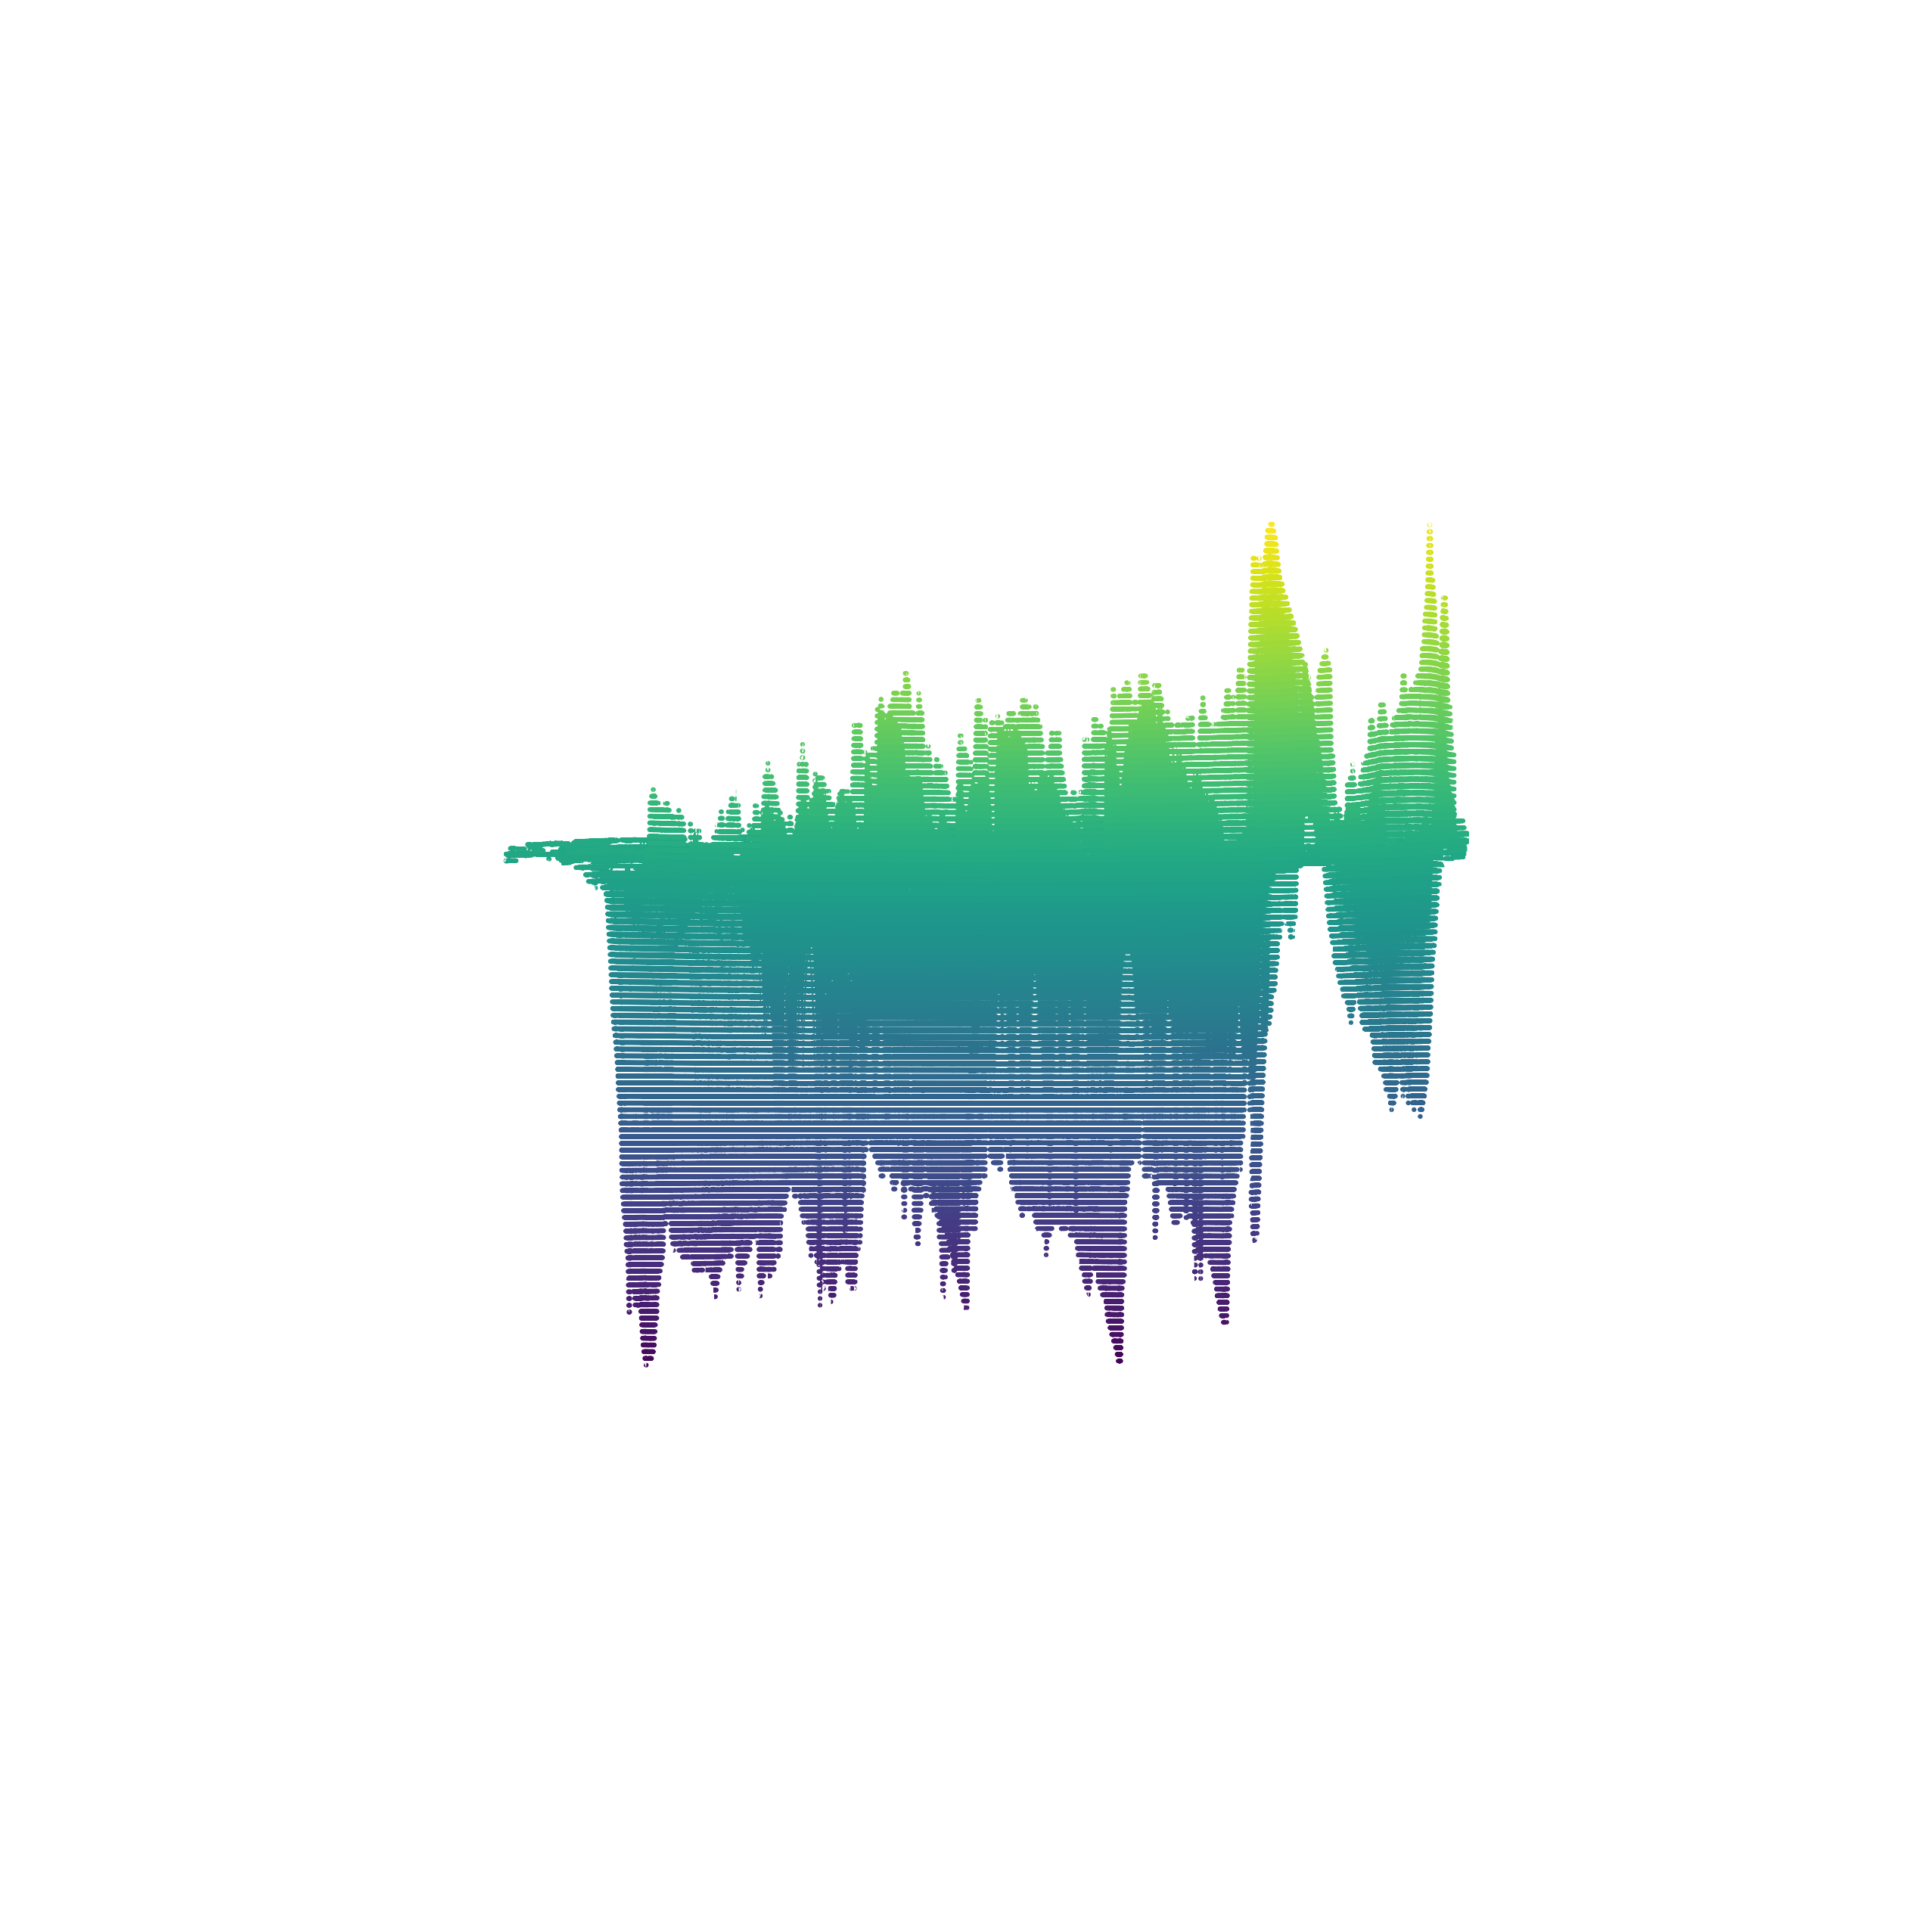

Total execution time: 745.99 seconds


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import time

# Start timing
start_time = time.time()

# Set figure size to 1920x1080 resolution with 300 DPI
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Parameters
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, 2 * np.pi, 50)
u, v = np.meshgrid(u, v)

# Create the 3D contour plot
contour = ax.contour3D(Xnew, Ynew, ELIYXTT, 150, cmap='viridis', vmax=np.amax(ELIYXTT), vmin=np.amin(ELIYXTT))

# Remove gridlines, axis, and background
ax.grid(False)
ax.set_axis_off()

# Animation function to update view angle (top-down and rotating around y-axis)
def update(frame):
    ax.view_init(elev=frame % 360, azim=0)  # Elevation fixed (side view), changing azimuth to simulate left-to-right flipping
    return fig,

# Create animation
frames = 360  # Full rotation over 360 frames
anim = FuncAnimation(fig, update, frames=frames, interval=1000/120)

# Save as GIF
anim.save('spinning_donut.gif', writer=PillowWriter(fps=60))

plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")

# Basic visualisation of the data

#### Top down

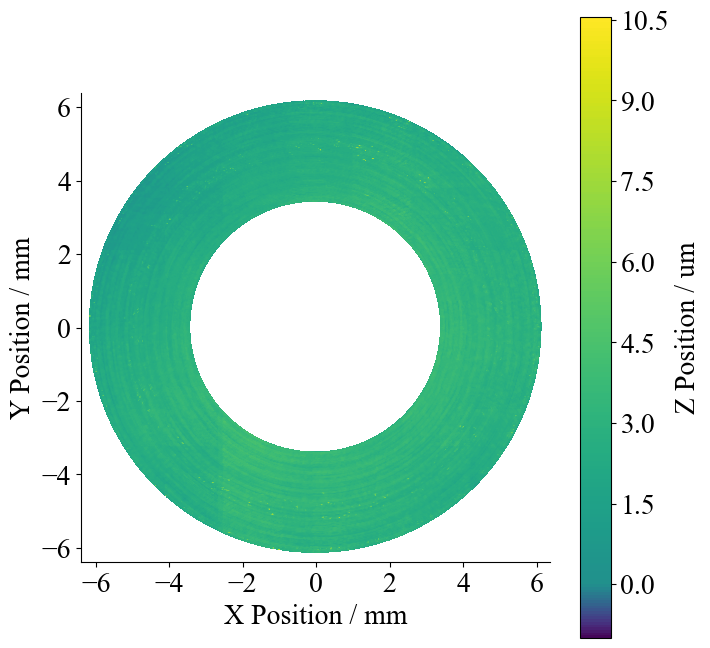

Total execution time: 31.70 seconds


In [65]:
# Creates a top down 2D plot

# Start timing
start_time = time.time()

# Create a figure and axis object
fig, ax = plt.subplots()

# Create a filled contour plot
norm = TwoSlopeNorm(vmin=ELIYXTT.min().min(), vcenter=0, vmax=ELIYXTT.max().max())
contour = ax.contourf(Xnew, Ynew, ELIYXTT, 256, norm=norm )
# for plotting without NORM: Xnew, Ynew, ELIYXTT, 256, vmax=np.amax(ELIYXTT.max()), vmin=np.amin(ELIYXTT.min()) )

# Set the title
# ax.set_title('Corrected Data')

# Set axis to be equal
ax.set_aspect('equal')

# Add a colorbar
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Z Position / um', fontsize = fsize)

# Use MaxNLocator to determine suitable ticks
cbar.locator = MaxNLocator(nbins=10)  # Increase the number of bins for more ticks
cbar.update_ticks()

cbar.ax.tick_params(labelsize = fsize) 

# Alternatively, you can set custom ticks manually
# cbar.set_ticks(np.linspace(np.amin(ELIYXTT.min()), np.amax(ELIYXTT.max()), num=15))

# Set color limits (again, this may be redundant but included for consistency)
contour.set_clim(vmax=np.amax(ELIYXTT.max()), vmin=np.amin(ELIYXTT.min()))

# Label the axes
ax.set_xlabel('X Position / mm', fontsize = fsize)
plt.xticks(fontsize = fsize)                  
ax.set_ylabel('Y Position / mm', fontsize = fsize)
plt.yticks(fontsize = fsize)                  

# Remove the top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adjust the layout to avoid overlap
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Resize the plot area
fig.set_size_inches(160/25.4, 160/25.4)

output = file_name.replace('.xyz', '_circle.png')
fig.savefig(output, dpi=150)

# Show the plot
plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")

#### Using a scale bar instead of tick marks

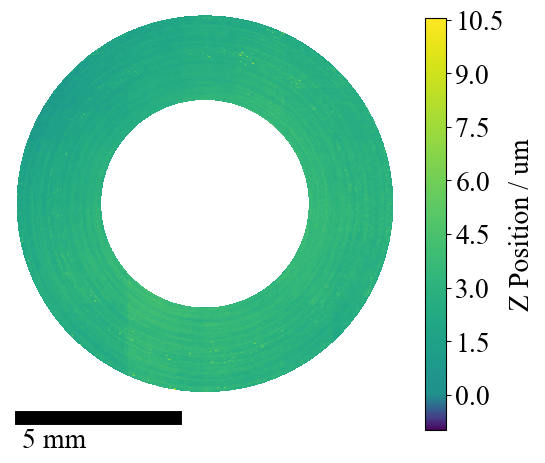

Total execution time: 31.96 seconds


In [66]:
# Start timing
start_time = time.time()

# Create a figure and axis object
fig, ax = plt.subplots()

# Create a filled contour plot
norm = TwoSlopeNorm(vmin=ELIYXTT.min().min(), vcenter=0, vmax=ELIYXTT.max().max())
contour = ax.contourf(Xnew, Ynew, ELIYXTT, 256, norm=norm)

# Set axis to be equal
ax.set_aspect('equal')

# Add a colorbar
cbar = fig.colorbar(contour, ax=ax, shrink=0.85)
cbar.set_label('Z Position / um', fontsize=fsize)

# Use MaxNLocator to determine suitable ticks
cbar.locator = MaxNLocator(nbins=10)
cbar.update_ticks()

cbar.ax.tick_params(labelsize=fsize)

# Set color limits
contour.set_clim(vmax=np.amax(ELIYXTT.max()), vmin=np.amin(ELIYXTT.min()))

# Turn off ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Remove all spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

# Add a scale bar of 10mm in the bottom left corner
scalebar_length = 5 #mm
x_pos = -6
y_pos = -7
ax.plot([x_pos, x_pos + scalebar_length], [y_pos, y_pos], color='black', lw=10)  # Thicker scale bar
ax.text(x_pos, y_pos - 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0]), '5 mm', fontsize=fsize, va='top')

# Resize the plot area
fig.set_size_inches(160/25.4, 160/25.4)

output = file_name.replace('.xyz', '_circle_scalebar.png')
fig.savefig(output, dpi=150)

# Show the plot
plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")

#### Side on

In [ ]:
# Creates a side on 2D plot

# Start timing
start_time = time.time()

# Generate X values as indices
x_values = np.arange(len(z_clean))

# Create the plot
plt.figure(figsize=(160/25.4, 80/25.4))
plt.scatter(x_values, z_clean, alpha = 0.05, s = 2)
plt.xlabel('Index')
plt.ylabel('Height/μm')
output = file_name.replace('.xyz', '_2D.png')


# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('2ndtilt_slice', dpi=150)

plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")

#### 3D (not currently saved as image)

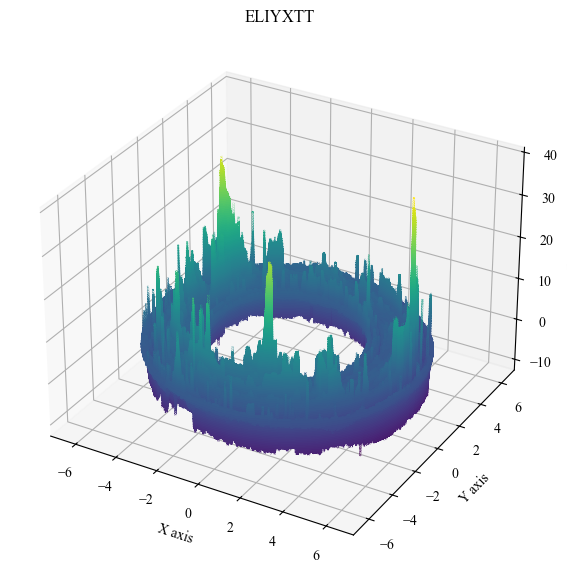

Total execution time: 16.28 seconds


In [98]:
# Creates a fun 3D plot

# Start timing
start_time = time.time()

# Create a figure and an axes for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D contour plot
contour = ax.contour3D(Xnew, Ynew, ELIYXTT, 150, cmap='viridis', vmax=np.amax(ELIYXTT), vmin=np.amin(ELIYXTT))

# Labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('ELIYXTT')

# Show the plot
plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")

# This code quantifies surface roughness

#### This code finds the Root mean square of the surface

In [99]:
# Calculate the mean
mean_value = np.mean(z_clean)
print(f"Mean of the array: {mean_value:.4g} µm")

# Calculate squared differences from the mean
squared_differences = np.square(z_clean - mean_value)
print("Squared differences from the mean:", squared_differences)

# Calculate the mean of the squared differences
mean_of_squared_differences = np.mean(squared_differences)
print(f"Mean of the squared differences: {mean_of_squared_differences:.4g} µm²")

# Calculate the RMS value
rms_value = np.sqrt(mean_of_squared_differences)
print(f"The RMS value of the 2D array is: {rms_value:.4g} µm")

Mean of the array: 2.176 µm
Squared differences from the mean: [0.13225742 0.03945391 0.04106729 ... 0.69200118 0.80481008 0.80348277]
Mean of the squared differences: 10.29 µm²
The RMS value of the 2D array is: 3.208 µm


#### This code uses top 5 and bottom 5 % of datapoints

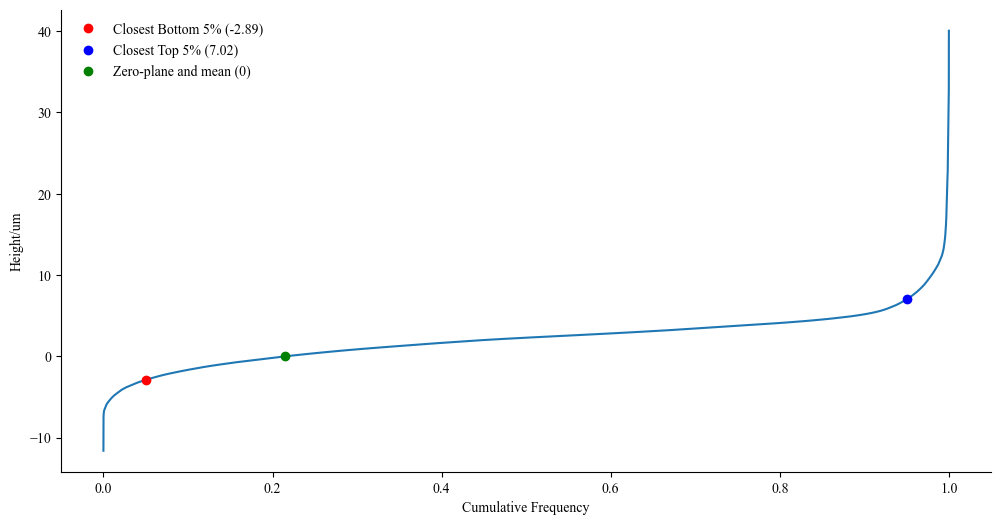

Bottom 5% points, area of 4.115 mm² (5.00% of points)
Top 5% points, area of 4.115 mm² (5.00% of points)


Using calculated area of sample to be 94.76 mm²
Below lower bound: 4.342%
Above upper bound: 4.342%


Trough volume of 0.01717 mm³
Peak volume of 0.04308 mm³
Total galled volume of 0.06025 mm³


Height at 5% cutoff (bottom): -2.889 µm
Height at 5% cutoff (top): 7.018 µm
Range of the data 9.907 µm


Total execution time: 7.82 seconds


In [100]:
# Calculate the percentage for top 5% and bottom 5%
percentile_cutoff = 0.05

# Start timing
start_time = time.time()

sorted_values = np.sort(z_clean)

# Shift the data so that the mean is at 0
shifted_values = sorted_values

# Recalculate cumulative counts
cumulative_counts = np.arange(1, len(shifted_values) + 1)
# Convert counts to normalized percentages
percentage_below = cumulative_counts / len(shifted_values)

# Calculate the number of data points that corresponds to 5% of the total data
n_points = len(shifted_values)
cutoff_count = int(n_points * percentile_cutoff)

# Select the bottom 5% and top 5% points
bottom_5_percent_values = shifted_values[:cutoff_count]
top_5_percent_values = shifted_values[-cutoff_count:]

# Find the point closest to the mean (0) for the bottom 5% and top 5%
closest_bottom_5_percent = bottom_5_percent_values[np.abs(bottom_5_percent_values).argmin()]
closest_top_5_percent = top_5_percent_values[np.abs(top_5_percent_values).argmin()]

# Calculate the height value at the 5% cutoff
height_at_bottom_5_percent = shifted_values[cutoff_count - 1]
height_at_top_5_percent = shifted_values[-cutoff_count]

#Finding the sample area and galled area
SA = math.pi*(6.35**2 - 3.1875**2) #From ASTM G196 sample drawing

# Plot the cumulative frequency distribution
plt.figure(figsize=(12, 6))
plt.plot(percentage_below, shifted_values)

# Plot the point closest to the mean for the bottom 5% and top 5%
plt.plot(percentage_below[np.searchsorted(shifted_values, closest_bottom_5_percent)],
         closest_bottom_5_percent, 'ro', label=f'Closest Bottom 5% ({closest_bottom_5_percent:.2f})')

plt.plot(percentage_below[np.searchsorted(shifted_values, closest_top_5_percent)],
         closest_top_5_percent, 'bo', label=f'Closest Top 5% ({closest_top_5_percent:.2f})')

# Plot the shifted mean point (now zero)
plt.plot(percentage_below[np.searchsorted(shifted_values, 0)], 0, 'go', label=f'Zero-plane and mean (0)')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Cumulative Frequency')
plt.ylabel('Height/um')
plt.legend(frameon=0)
plt.tight_layout
plt.savefig('points5%.png', dpi = 150)
plt.show()

# Volumes in mm^3 for 5% data points
volumes_below_lower_bound = np.sum(bottom_5_percent_values/1000 * pixel_size)
volumes_above_upper_bound = np.sum(top_5_percent_values/1000 * pixel_size)

# Calculate number of points and percentages
points_below_lower_bound = len(bottom_5_percent_values)
points_above_upper_bound = len(top_5_percent_values)

percentage_bottom_5_percent = points_below_lower_bound / len(shifted_values) * 100
percentage_top_5_percent = points_above_upper_bound / len(shifted_values) * 100

# Print the results
print(f'Bottom 5% points, area of {points_below_lower_bound * pixel_size:.4g} mm² ({percentage_bottom_5_percent:.2f}% of points)')
print(f'Top 5% points, area of {points_above_upper_bound * pixel_size:.4g} mm² ({percentage_top_5_percent:.2f}% of points)')
print('\n')
# Print percentages relative to the sample area
print(f'Using calculated area of sample to be {SA:.4g} mm²')
print(f'Below lower bound: {points_below_lower_bound * pixel_size / SA * 100:.4g}%')
print(f'Above upper bound: {points_above_upper_bound * pixel_size / SA * 100:.4g}%')
print('\n')
# Print volumn of peak and trough in mm^3
print(f'Trough volume of {abs(volumes_below_lower_bound):.4g} mm³')
print(f'Peak volume of {volumes_above_upper_bound:.4g} mm³')
print(f'Total galled volume of {abs(volumes_below_lower_bound) + volumes_above_upper_bound:.4g} mm³')
print('\n')
# Print the height values at 5% cutoff
print(f'Height at 5% cutoff (bottom): {height_at_bottom_5_percent:.4g} µm')
print(f'Height at 5% cutoff (top): {height_at_top_5_percent:.4g} µm')
print(f'Range of the data {height_at_top_5_percent - height_at_bottom_5_percent:.4g} µm')
print('\n')

# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")

#### This version uses 5% by range so anything below or above the 5% mark

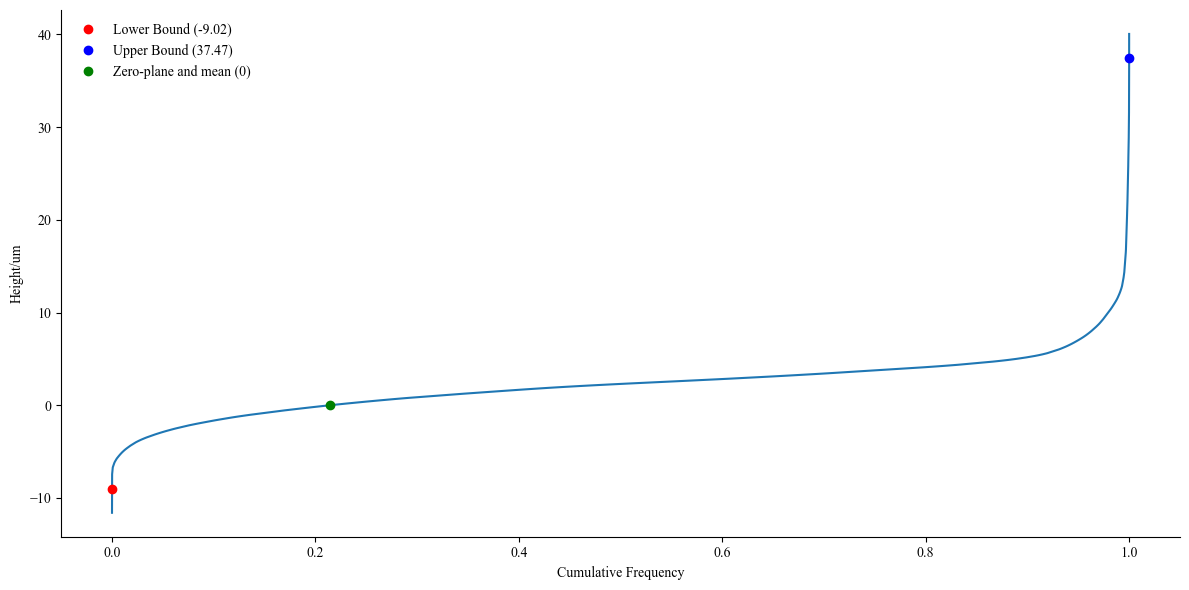

Below lower bound: 22 points, with an area of 0.000146 mm² (0.00% of points)
Above upper bound: 88 points, with an area of 0.0005839 mm² (0.00% of points)


Using calculated area of sample to be 94.76 mm²
Below lower bound: 0.0001541%
Above upper bound: 0.0006163%


Trough volume of 1.488e-06 mm³
Peak volume of 2.231e-05 mm³
Total galled volume of 2.38e-05 mm³


Total execution time: 9.55 seconds


In [102]:
# Start timing
start_time = time.time()

sorted_values = np.sort(z_clean)

# Shift the data so that the mean is at 0
shifted_values = sorted_values

# Recalculate cumulative counts
cumulative_counts = np.arange(1, len(shifted_values) + 1)
# Convert counts to normalized percentages
percentage_below = cumulative_counts / len(shifted_values)

# Calculate range and determine the top and bottom 5%
data_range = np.max(shifted_values) - np.min(shifted_values)
lower_bound = np.min(shifted_values) + 0.05 * data_range
upper_bound = np.max(shifted_values) - 0.05 * data_range

# Filter values outside the acceptable range
below_lower_bound_values = shifted_values[shifted_values < lower_bound]
above_upper_bound_values = shifted_values[shifted_values > upper_bound]

# Calculate how many points are outside the acceptable range
points_below_lower_bound = len(below_lower_bound_values)
points_above_upper_bound = len(above_upper_bound_values)

percentage_below_lower_bound = points_below_lower_bound / len(shifted_values) * 100
percentage_above_upper_bound = points_above_upper_bound / len(shifted_values) * 100

# Volume calculation for points in mm^3
volumes_below_lower_bound = np.sum(below_lower_bound_values / 1000 * pixel_size)
volumes_above_upper_bound = np.sum(above_upper_bound_values / 1000 * pixel_size)

# Finding the sample area and galled area
SA = math.pi * (6.35**2 - 3.1875**2)  # From ASTM G196 sample drawing

# Plot the cumulative frequency distribution
plt.figure(figsize=(12, 6))
plt.plot(percentage_below, shifted_values)

# Plot the values outside the acceptable range
plt.plot(percentage_below[np.searchsorted(shifted_values, lower_bound)], lower_bound, 'ro', label=f'Lower Bound ({lower_bound:.2f})')
plt.plot(percentage_below[np.searchsorted(shifted_values, upper_bound)], upper_bound, 'bo', label=f'Upper Bound ({upper_bound:.2f})')

# Plot the shifted mean point (now zero)
plt.plot(percentage_below[np.searchsorted(shifted_values, 0)], 0, 'go', label='Zero-plane and mean (0)')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Cumulative Frequency')
plt.ylabel('Height/um')
plt.legend(frameon=0)
plt.tight_layout()
plt.savefig('range5%.png', dpi=150)
plt.show()

# Print the results
print(f'Below lower bound: {points_below_lower_bound} points, with an area of {points_below_lower_bound * pixel_size:.4g} mm² ({percentage_below_lower_bound:.2f}% of points)')
print(f'Above upper bound: {points_above_upper_bound} points, with an area of {points_above_upper_bound * pixel_size:.4g} mm² ({percentage_above_upper_bound:.2f}% of points)')
print('\n')
# Print percentages relative to the sample area
print(f'Using calculated area of sample to be {SA:.4g} mm²')
print(f'Below lower bound: {points_below_lower_bound * pixel_size / SA * 100:.4g}%')
print(f'Above upper bound: {points_above_upper_bound * pixel_size / SA * 100:.4g}%')
print('\n')
# Print volume of peak and trough in mm^3
print(f'Trough volume of {abs(volumes_below_lower_bound):.4g} mm³')
print(f'Peak volume of {volumes_above_upper_bound:.4g} mm³')
print(f'Total galled volume of {abs(volumes_below_lower_bound) + volumes_above_upper_bound:.4g} mm³')
print('\n')

# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")


#### This code uses threshold from mean

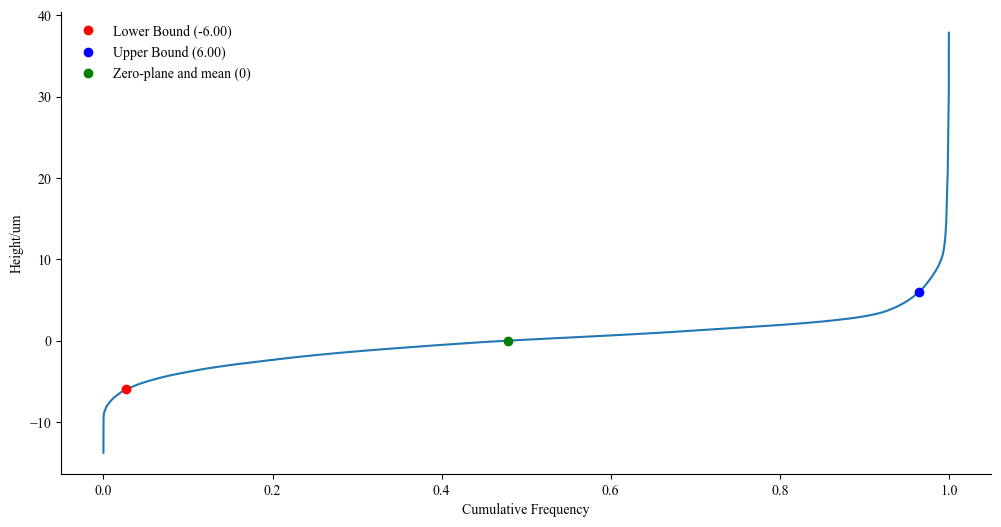

Below lower bound: 330296 points, with an area of 2.192 mm² (2.66% of points)
Above upper bound: 437435 points, with an area of 2.903 mm² (3.53% of points)


Using calculated area of sample to be 94.76 mm²
Below lower bound: 2.313%
Above upper bound: 3.063%


Trough volume of 0.01556 mm³
Peak volume of 0.0276 mm³
Total galled volume of 0.04316 mm³


Total execution time: 7.40 seconds


In [103]:
# Set a threshold range around the mean (which is now 0)
threshold = 6  # Adjust this value to your needs

# Start timing
start_time = time.time()

sorted_values = np.sort(z_clean)

# Calculate the mean
mean_value = sorted_values.mean()

# Shift the data so that the mean is at 0
shifted_values = sorted_values - mean_value

# Recalculate cumulative counts
cumulative_counts = np.arange(1, len(shifted_values) + 1)
# Convert counts to normalized percentages
percentage_below = cumulative_counts / len(shifted_values)

lower_bound = -threshold
upper_bound = threshold

# --- The range is picked -----------------------------------------------------------------------------------------------------------------------------------------------------

# Filter values outside the acceptable range
below_lower_bound_values = shifted_values[shifted_values < lower_bound]
above_upper_bound_values = shifted_values[shifted_values > upper_bound]

# Calculate how many points are outside the acceptable range
points_below_lower_bound = len(below_lower_bound_values)
points_above_upper_bound = len(above_upper_bound_values)

percentage_below_lower_bound = points_below_lower_bound / len(shifted_values) * 100
percentage_above_upper_bound = points_above_upper_bound / len(shifted_values) * 100

# Volume calculation for points in mm^3
volumes_below_lower_bound = np.sum(below_lower_bound_values/1000 * pixel_size)
volumes_above_upper_bound = np.sum(above_upper_bound_values/1000 * pixel_size)

#Finding the sample area and galled area
SA = math.pi*(6.35**2 - 3.1875**2) #From ASTM G196 sample drawing

# Plot the cumulative frequency distribution
plt.figure(figsize=(12, 6))
plt.plot(percentage_below, shifted_values)

# Plot the values outside the acceptable range
plt.plot(percentage_below[np.searchsorted(shifted_values, lower_bound)], lower_bound, 'ro', label=f'Lower Bound ({lower_bound:.2f})')
plt.plot(percentage_below[np.searchsorted(shifted_values, upper_bound)], upper_bound, 'bo', label=f'Upper Bound ({upper_bound:.2f})')

# Plot the shifted mean point (now zero)
plt.plot(percentage_below[np.searchsorted(shifted_values, 0)], 0, 'go', label=f'Zero-plane and mean (0)')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Cumulative Frequency')
plt.ylabel('Height/um')
plt.legend(frameon=0)
plt.tight_layout
plt.savefig('mean.png', dpi = 150)
plt.show()

# Print the results
print(f'Below lower bound: {points_below_lower_bound} points, with an area of {points_below_lower_bound * pixel_size:.4g} mm² ({percentage_below_lower_bound:.2f}% of points)')
print(f'Above upper bound: {points_above_upper_bound} points, with an area of {points_above_upper_bound * pixel_size:.4g} mm² ({percentage_above_upper_bound:.2f}% of points)')
print('\n')
# Print percentages relative to the sample area
print(f'Using calculated area of sample to be {SA:.4g} mm²')
print(f'Below lower bound: {points_below_lower_bound * pixel_size / SA * 100:.4g}%')
print(f'Above upper bound: {points_above_upper_bound * pixel_size / SA * 100:.4g}%')
print('\n')
# Print volumn of peak and trough in mm^3
print(f'Trough volume of {abs(volumes_below_lower_bound):.4g} mm³')
print(f'Peak volume of {volumes_above_upper_bound:.4g} mm³')
print(f'Total galled volume of {abs(volumes_below_lower_bound) + volumes_above_upper_bound:.4g} mm³')
print('\n')

# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")

#### This code uses threshold from median (zero-plane)

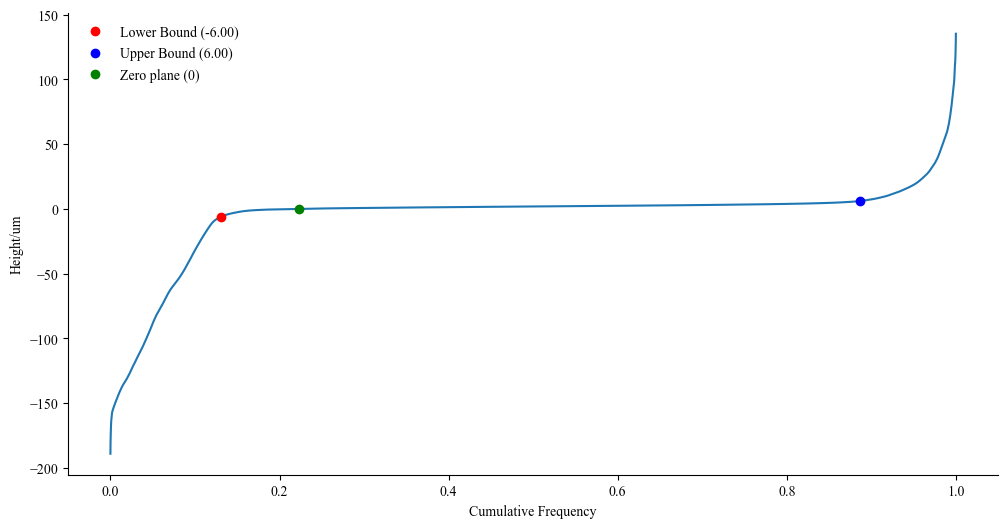

Below lower bound: 1617720 points, with an area of 10.73 mm² (13.07% of points)
Above upper bound: 1405335 points, with an area of 9.325 mm² (11.36% of points)


Using calculated area of sample to be 94.76 mm²
Below lower bound: 11.33%
Above upper bound: 9.841%


Trough volume of 0.7366 mm³
Peak volume of 0.2862 mm³
Total galled volume of 1.023 mm³


Total execution time: 7.19 seconds


In [77]:
# Set a threshold range around the median
threshold = 6  # Adjust this value to your needs

# Start timing
start_time = time.time()

sorted_values = np.sort(z_clean)

# Recalculate cumulative counts
cumulative_counts = np.arange(1, len(sorted_values) + 1)
# Convert counts to normalized percentages
percentage_below = cumulative_counts / len(sorted_values)

lower_bound = -threshold
upper_bound = threshold

# --- The range is picked -----------------------------------------------------------------------------------------------------------------------------------------------------

# Filter values outside the acceptable range
below_lower_bound_values = shifted_values[sorted_values < lower_bound]
above_upper_bound_values = shifted_values[sorted_values > upper_bound]

# Calculate how many points are outside the acceptable range
points_below_lower_bound = len(below_lower_bound_values)
points_above_upper_bound = len(above_upper_bound_values)

percentage_below_lower_bound = points_below_lower_bound / len(sorted_values) * 100
percentage_above_upper_bound = points_above_upper_bound / len(sorted_values) * 100

# Volume calculation for points in mm^3
volumes_below_lower_bound = np.sum(below_lower_bound_values/1000 * pixel_size)
volumes_above_upper_bound = np.sum(above_upper_bound_values/1000 * pixel_size)

#Finding the sample area and galled area
SA = math.pi*(6.35**2 - 3.1875**2) #From ASTM G196 sample drawing


# Plot the cumulative frequency distribution
plt.figure(figsize=(12, 6))
plt.plot(percentage_below, sorted_values)

# Plot the values outside the acceptable range
plt.plot(percentage_below[np.searchsorted(sorted_values, lower_bound)], lower_bound, 'ro', label=f'Lower Bound ({lower_bound:.2f})')
plt.plot(percentage_below[np.searchsorted(sorted_values, upper_bound)], upper_bound, 'bo', label=f'Upper Bound ({upper_bound:.2f})')

# Plot the shifted mean point (now zero)
plt.plot(percentage_below[np.searchsorted(sorted_values, 0)], 0, 'go', label=f'Zero plane (0)')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Cumulative Frequency')
plt.ylabel('Height/um')
plt.legend(frameon=0)
plt.tight_layout
plt.savefig('median.png', dpi = 150)
plt.show()

# Print the results
print(f'Below lower bound: {points_below_lower_bound} points, with an area of {points_below_lower_bound * pixel_size:.4g} mm² ({percentage_below_lower_bound:.2f}% of points)')
print(f'Above upper bound: {points_above_upper_bound} points, with an area of {points_above_upper_bound * pixel_size:.4g} mm² ({percentage_above_upper_bound:.2f}% of points)')
print('\n')
# Print percentages relative to the sample area
print(f'Using calculated area of sample to be {SA:.4g} mm²')
print(f'Below lower bound: {points_below_lower_bound * pixel_size / SA * 100:.4g}%')
print(f'Above upper bound: {points_above_upper_bound * pixel_size / SA * 100:.4g}%')
print('\n')
# Print volumn of peak and trough in mm^3
print(f'Trough volume of {abs(volumes_below_lower_bound):.4g} mm³')
print(f'Peak volume of {volumes_above_upper_bound:.4g} mm³')
print(f'Total galled volume of {abs(volumes_below_lower_bound) + volumes_above_upper_bound:.4g} mm³')
print('\n')
# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")

# This code helps visualize tilt correction

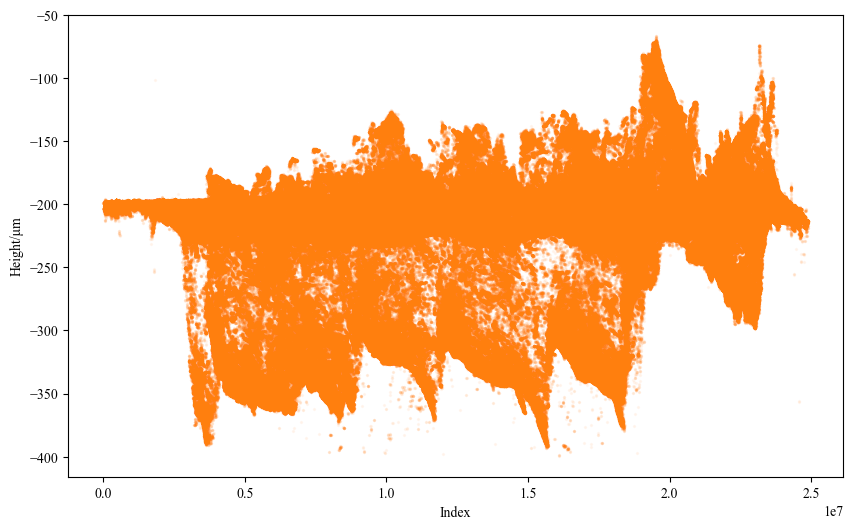

Total execution time: 7.37 seconds


In [78]:
# Start timing
start_time = time.time()

data = raw_data.to_numpy()

# Flatten the array to get all Z values
z_values = data.flatten()

# Generate X values as indices
x_values = np.arange(len(z_values))

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, z_values, alpha = 0.05, s = 2, color = "tab:orange")
plt.xlabel('Index')
plt.ylabel('Height/μm')
output = file_name.replace('.xyz', '_2D.png')
plt.savefig('raw_Data.png', dpi=150)
plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")

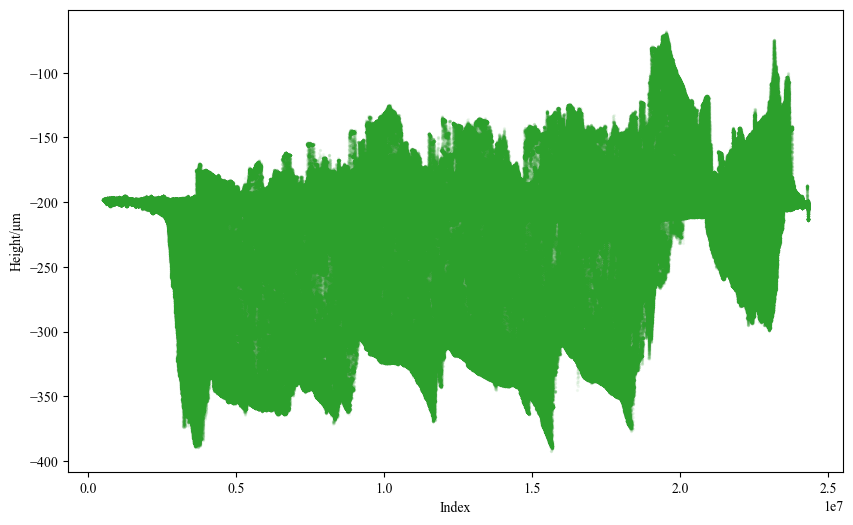

Total execution time: 6.48 seconds


In [79]:
# Start timing
start_time = time.time()

data = ELIX2.to_numpy()

# Flatten the array to get all Z values
z_values = data.flatten()

# Generate X values as indices
x_values = np.arange(len(z_values))

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, z_values, alpha = 0.05, s = 2, color = "tab:green")
plt.xlabel('Index')
plt.ylabel('Height/μm')
output = file_name.replace('.xyz', '_2D.png')
plt.savefig('1st_tilt.png', dpi=150)
plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")

In [80]:
start_time = time.time()

# Example of how you might have multiple dataframes (replace this with your actual setup)
dataframes = [raw_data, ELIX2, ELIYXTT]
labels = ['raw_data', 'ELIX2', 'ELIYXTT']
colors = ['tab:orange', 'tab:green', 'tab:blue']

plt.figure(figsize=(160/25.4, 80/25.4))

# Iterate over each dataframe
for idx, df in enumerate(dataframes):
    # Convert dataframe to numpy array outside the loop
    data = data.to_numpy()
    
    # Flatten the array to get all Z values
    z_values = data.flatten()

    # Downsample the data to speed up plotting, e.g., plot every 10th point
    if idx == 0:
        step = 2
    else:
        step = 10  # Change step size based on your dataset
    
    x_values = np.arange(len(z_values))[::step]
    z_values = z_values[::step]

    # Create the plot for each dataframe
    plt.scatter(x_values, z_values, alpha=0.2, s=1, label=labels[idx], color=colors[idx])

plt.xlabel('Index')
plt.ylabel('Z')
legend = plt.legend(loc= 1,frameon=False)

for handle in legend.legendHandles:
    handle.set_alpha(1)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Save the figure
plt.savefig('allstakced.png', dpi=150)

plt.show()

# End timing for the whole process
end_time = time.time()

# Print the timing results
print(f"Total execution time: {end_time - start_time:.2f} seconds")

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

<Figure size 629.921x314.961 with 0 Axes>

# This is Sams old galling area code, im keeping here because its good to check the code outputs the same numbers

In [ ]:
#Finding the galled area and displaced volumes using the Cumulative Frequency Distribution
Ra = 6 #Ra in um

Zsortnan = np.sort(np.ndarray.flatten(np.asarray(ELIYXTT)))
Zsort = Zsortnan[~np.isnan(Zsortnan)]

#Size of each pixel for corrected sample
Xnewsize = 0.003484/(XTilt1*XTilt2*XTilt3)
Ynewsize = 0.003484/(YTilt1*YTilt2*YTilt3)

for i in range(0, len(Zsort), 1):
    if Zsort[i]>-Ra:
        ineg = i
        print('ineg: ', ineg)
        break
    else:
        continue
    
    
for i in range(ineg, len(Zsort), 1):
    if Zsort[i]>Ra:
        ipos = i
        print('ipos: ', ipos)
        break
    else:
        continue

#Finding the sample area and galled area
SA = math.pi*(6.35**2 - 3.1875**2) #From ASTM G196 sample drawing

if 100*Xnewsize*Ynewsize*(ineg+(len(Zsort)-ipos))/SA <= 0:
    GA = 0
else:
    GA = 100*Xnewsize*Ynewsize*(ineg+(len(Zsort)-ipos))/SA

if ineg==0:
    DVneg = 0
else:
    DVneg = -np.sum(Zsort[0:ineg-1])*Xnewsize*Ynewsize/1000
    
DVpos = np.sum(Zsort[ipos:])*Xnewsize*Ynewsize/1000
DVtot = DVneg + DVpos

TGA = 100*Xnewsize*Ynewsize*(ineg)/SA
PGA = 100*Xnewsize*Ynewsize*((len(Zsort)-ipos))/SA

print('List length:',len(Zsort))
print('Trough Area / %: ', TGA)
print('Peak Area / %: ', PGA)
print('Galled Area / %: ', GA)
print()
print('Trough Volume (mm3): ', DVneg)
print('Peak Volume (mm3): ', DVpos)
print('Total Galled Volume (mm3): ', DVtot)
print()
print('Xszie,Ysize:',Xnewsize*Ynewsize)
print('Pixel size:',pixel_size)
print('surafce area:',SA)